# Flower recognition using pytorch 

# Importing Libraries

In [1]:
# Package imports
import numpy as np
import sklearn
import sklearn.linear_model
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import os
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns

from sklearn.model_selection import train_test_split

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# PART 1

### 1-Load the dataset and show sample from each folder\class. 

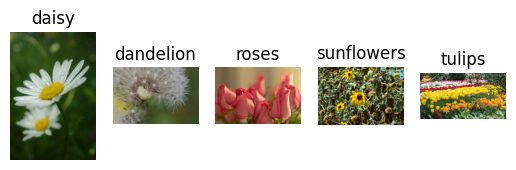

In [2]:
# dataset = ImageFolder('./flower_photos/train', transform=transform) I will load the data in the next cell with transforms, now I'll just show samples
root_train = '/kaggle/input/flower-photos/flower_photos/train/'
root_test = '/kaggle/input/flower-photos/flower_photos/test/'

classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

samples = []
for flower_class in classes:
    folder = os.path.join(root_train, flower_class)
    sample_image = os.listdir(folder)[0]  # just take the first image as a sample
    image_path = os.path.join(folder, sample_image)
    samples.append(mpimg.imread(image_path))

# Display sample images
for i, (flower_class, img) in enumerate(zip(classes, samples)):
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(flower_class)
    plt.axis('off')
plt.show()


### 2-Prepare the data by performing the following:
a. Divid the train data into train (80%) and validation (20%) <br> b. Preprocess the data. <br> c. Perform data augmentation (Rotation with angle 20 and Horizontal flipping). You should do these augmentations to the correct set(s). 

In [3]:
# c: Define transformations to perfrom data augementation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((150, 150)),  # Resize images to a single standard size. I chose 150x150 because it is not too large to be computationally intensive nor too small to lose critical details
        # Start part C: Data augmentation #
        transforms.RandomRotation(20),  # Rotation augmentation by 20 degrees (specified in part C)
        transforms.RandomHorizontalFlip(),  # Horizontal flip augmentation (specified in part C) 
        # End of part C: Data augmentation #
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ]),
    'test': transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}
# Load datasets
train_dataset = ImageFolder(root_train, transform=data_transforms['train'])
test_dataset = ImageFolder(root_test, transform=data_transforms['test'])
# Split train dataset into training and validation
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

# Create dataloaders
train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


### 3-Implement the following model in Pytorch. The specifications of each layer are given under it. All convolution and FC layers are followed by ReLU activation function except the classification layer.

In [7]:
class FlowerClassifier(nn.Module):
  def __init__(self): # constructing the archetecture of the model
    super(FlowerClassifier, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=1, padding=0) 
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=7, stride=1, padding=0)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=1)
    self.dropout = nn.Dropout(p=0.5)
    self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=0)
    self.bn = nn.BatchNorm2d(16)
    self.fc1 = nn.Linear(63504, 1024) 
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 5) # 5 classes for the 5 flowers 
  def forward(self, x):
    x = F.relu(self.conv1(x)) # relu activation function after conv1
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.dropout(x)
    x = F.relu(self.conv4(x))
    x = self.bn(x)
    x = x.view(x.size(0), -1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x) # No need to apply softmax as pytorch use cross-entropy as activation.
    return x

### 4  Your implementation should include the following:
a. Use early stopping to avoid overfitting
<br>
b. Show the loss and accuracy of the train and validation data 
<br> c. Plot the loss of the train and validation data in one figure 
<br> d. Plot the accuracy of the train and validation data in one figure
<br> e. Show the accuracy of the test data

In [5]:
# utilizing the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Epoch 1/20 - Train Loss: 1.5303  Train Acc: 0.3499  Val Loss: 2.5691  Val Acc: 0.2696
Epoch 2/20 - Train Loss: 1.2932  Train Acc: 0.4376  Val Loss: 2.1964  Val Acc: 0.3272
Epoch 3/20 - Train Loss: 1.2105  Train Acc: 0.4746  Val Loss: 2.1164  Val Acc: 0.3664
Epoch 4/20 - Train Loss: 1.1764  Train Acc: 0.5173  Val Loss: 2.2645  Val Acc: 0.2903
Epoch 5/20 - Train Loss: 1.1148  Train Acc: 0.5727  Val Loss: 1.3879  Val Acc: 0.4378
Epoch 6/20 - Train Loss: 1.1211  Train Acc: 0.5583  Val Loss: 1.2287  Val Acc: 0.5323
Epoch 7/20 - Train Loss: 1.0437  Train Acc: 0.5843  Val Loss: 1.3650  Val Acc: 0.4309
Epoch 8/20 - Train Loss: 1.0244  Train Acc: 0.5993  Val Loss: 1.2867  Val Acc: 0.4977
Epoch 9/20 - Train Loss: 1.0418  Train Acc: 0.5912  Val Loss: 1.2583  Val Acc: 0.4700
Early stopping at epoch 9


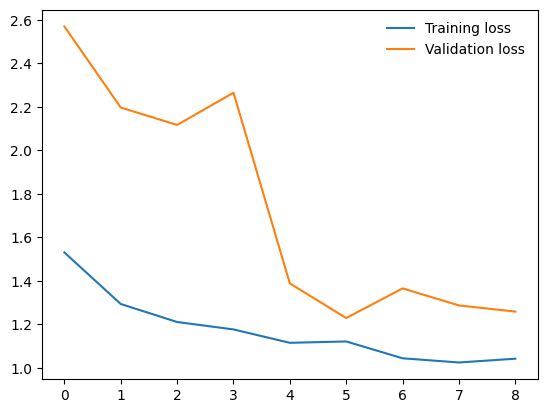

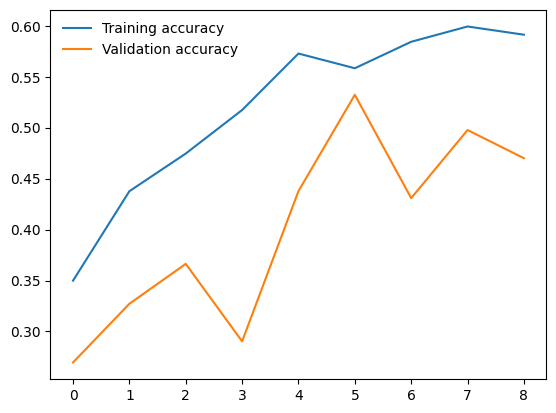

Test Loss: 1.3786  Test Acc: 0.4300


In [8]:
# preparing for part a: early stopping class
class EarlyStopper: 
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
# prepare part b-d: Functions for plotting and accuracy function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    corrects = torch.sum(preds == labels.data)
    return corrects.double() / labels.size(0)

def plot_train_val_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()

def plot_train_val_accuracy(train_accuracies, val_accuracies):
    # I got error using GPU. So, Convert tensors to numpy arrays after moving to CPU
    train_accuracies = [t.cpu().numpy() for t in train_accuracies]
    val_accuracies = [t.cpu().numpy() for t in val_accuracies]
    plt.plot(train_accuracies, label='Training accuracy')
    plt.plot(val_accuracies, label='Validation accuracy')
    plt.legend(frameon=False)
    plt.show()

# part a to d: training and showing results
# Initialize the model, loss function, and optimizer
model = FlowerClassifier()
model.to(device) # Move the model to the device (GPU)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

early_stopper = EarlyStopper(patience=3, min_delta=0.001)
num_epochs = 20

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training loop
    model.train()  # set the model to training mode
    train_loss = 0.0
    train_corrects = 0
    for inputs, labels in train_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        
        train_corrects += accuracy(outputs, labels) * labels.size(0)

    # Validation loop
    model.eval()  # set the model to evaluation mode
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            val_corrects += accuracy(outputs, labels) * labels.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(valid_loader.dataset)
    
    train_accuracy = train_corrects / len(train_loader.dataset)
    val_accuracy = val_corrects / len(valid_loader.dataset)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}  Train Acc: {train_accuracy:.4f}  "
          f"Val Loss: {val_loss:.4f}  Val Acc: {val_accuracy:.4f}")
    if early_stopper.early_stop(val_loss):
            print(f"Early stopping at epoch {epoch + 1}")
            break
# Plotting
plot_train_val_loss(train_losses, val_losses)
plot_train_val_accuracy(train_accuracies, val_accuracies)

# part e: showing the accuracy on test data
model.eval()  # set the model to evaluation mode
test_corrects = 0
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
        test_corrects += accuracy(outputs, labels) * labels.size(0)

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = test_corrects / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}  Test Acc: {test_accuracy:.4f}")

### 5. Show the performance of the following optimizers: Gradient Descent, SGD, AdaGrad, RMSProp, and Adam. Then, use the one with the best performance for the following steps. 

```First I will create a function to use it to train all models and obtain losses and accuracies```

In [59]:
def accuracy_s(outputs, labels): # this is the same accuracy function I used above, but I faced an issue. so this is a working around.
    _, preds = torch.max(outputs, 1)
    corrects = torch.sum(preds == labels.data)
    return corrects.double() / labels.size(0)

def train_validate_model(optimizer_name, model_instance, optimizer, criterion, train_loader, val_loader, epochs, device):
    # Lists to store loss and accuracy values
    # model_instance.to(device)  # Move the model to the device (GPU)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    early_stopper = EarlyStopper(patience=3, min_delta=0.001)
    print(f"==== Results for {optimizer_name} ====")
    for epoch in range(epochs):
        # Training loop
        model_instance.train()  # set the model to training mode
        train_loss = 0.0
        train_corrects = 0
        for inputs, labels in train_loader:
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model_instance(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

            train_corrects += accuracy_s(outputs, labels) * labels.size(0)

        # Validation loop
        model_instance.eval()  # set the model to evaluation mode
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move inputs and labels to the device
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model_instance(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                val_corrects += accuracy_s(outputs, labels) * labels.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)

        train_accuracy = train_corrects / len(train_loader.dataset)
        val_accuracy = val_corrects / len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}  Train Acc: {train_accuracy:.4f}  "
              f"Val Loss: {val_loss:.4f}  Val Acc: {val_accuracy:.4f}")

        if early_stopper.early_stop(val_loss):
            print(f"Early stopping at epoch {epoch + 1}")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies


In [10]:

results = []
criterion = nn.CrossEntropyLoss()
epochs = 20

# Gradient Descent (GD)
model_gd = FlowerClassifier()
model_gd.to(device)
optimizer_gd = optim.SGD(model_gd.parameters(), lr=0.001, momentum=0)  # Gradient Descent (GD) is just SGD without momentum.
train_losses, val_losses, train_accuracies, val_accuracies = train_validate_model("GD", model_gd, optimizer_gd, criterion, train_loader, valid_loader, epochs, device)
# I'll use the final validation accuracy. to compare optimizers
final_val_accuracy = val_accuracies[-1]
results.append(("GD", final_val_accuracy))

# SGD with momentum =0.9
model_sgd = FlowerClassifier()
model_sgd.to(device)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.001, momentum=0.9)  # Stochastic Gradient Descent with momentum
train_losses, val_losses, train_accuracies, val_accuracies = train_validate_model("SGD", model_sgd, optimizer_sgd, criterion, train_loader, valid_loader, epochs, device)
final_val_accuracy = val_accuracies[-1]
results.append(("SGD", final_val_accuracy))

# AdaGrad
model_adagrad = FlowerClassifier()
model_adagrad.to(device)
optimizer_adagrad = optim.Adagrad(model_adagrad.parameters(), lr=0.001)
train_losses, val_losses, train_accuracies, val_accuracies = train_validate_model("AdaGrad", model_adagrad, optimizer_adagrad, criterion, train_loader, valid_loader, epochs, device)
final_val_accuracy = val_accuracies[-1]
results.append(("AdaGrad", final_val_accuracy))

# RMSProp
model_rmsprop = FlowerClassifier()
model_rmsprop.to(device)
optimizer_rmsprop = optim.RMSprop(model_rmsprop.parameters(), lr=0.001)
train_losses, val_losses, train_accuracies, val_accuracies = train_validate_model("RMSProp", model_rmsprop, optimizer_rmsprop, criterion, train_loader, valid_loader, epochs, device)
final_val_accuracy = val_accuracies[-1]
results.append(("RMSProp", final_val_accuracy))

# Adam
model_adam = FlowerClassifier()
model_adam.to(device)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)
train_losses, val_losses, train_accuracies, val_accuracies = train_validate_model("Adam", model_adam, optimizer_adam, criterion, train_loader, valid_loader, epochs, device)
final_val_accuracy = val_accuracies[-1]
results.append(("Adam", final_val_accuracy))




results.sort(key=lambda x: x[1], reverse=True)

# Display results
for name, accuracy in results:
    print(f"Optimizer: {name}, Final Validation Accuracy: {(accuracy * 100):.2f}%")

# Choose the best optimizer
best_optimizer_name, accuracy = results[0]
print(f"Best Optimizer: {best_optimizer_name} with validation score: {(accuracy * 100):.2f}%")

model_gd = None
model_sgd = None
model_adagrad = None
model_rmsprop = None
model_adam = None


==== Results for GD ====
Epoch 1/20 - Train Loss: 1.5694  Train Acc: 0.3314  Val Loss: 1.4931  Val Acc: 0.3848
Epoch 2/20 - Train Loss: 1.4087  Train Acc: 0.4544  Val Loss: 1.2909  Val Acc: 0.4793
Epoch 3/20 - Train Loss: 1.2429  Train Acc: 0.4902  Val Loss: 1.1777  Val Acc: 0.5346
Epoch 4/20 - Train Loss: 1.1496  Train Acc: 0.5271  Val Loss: 1.1392  Val Acc: 0.5461
Epoch 5/20 - Train Loss: 1.0925  Train Acc: 0.5479  Val Loss: 1.1114  Val Acc: 0.5392
Epoch 6/20 - Train Loss: 1.0412  Train Acc: 0.5924  Val Loss: 1.1147  Val Acc: 0.5115
Epoch 7/20 - Train Loss: 1.0045  Train Acc: 0.5935  Val Loss: 1.7498  Val Acc: 0.4194
Epoch 8/20 - Train Loss: 0.9735  Train Acc: 0.6299  Val Loss: 1.2051  Val Acc: 0.5023
Early stopping at epoch 8
==== Results for SGD ====
Epoch 1/20 - Train Loss: 1.4105  Train Acc: 0.3845  Val Loss: 1.2530  Val Acc: 0.4700
Epoch 2/20 - Train Loss: 1.1770  Train Acc: 0.5000  Val Loss: 1.3518  Val Acc: 0.4654
Epoch 3/20 - Train Loss: 1.0788  Train Acc: 0.5502  Val Loss: 1

### 6 Perform a random search to select the following model’s hyperparameters: Learning rate, Regularization strength. In addition to the code, you should show the best obtained values of these two hyperparameters

In [20]:
# I will keep the momentum as is
# torch.cuda.empty_cache()
# Defining the hyperparameters space
lr_space = np.logspace(-4, 0, 50)
reg_space = np.logspace(-5, -3, 50)

# Randomly sample from the hyperparameter space
rand_lr_values = np.random.choice(lr_space, 5) # 5 is too small, but I don't have computatinoal resources
rand_reg_values = np.random.choice(reg_space, 5) 

best_accuracy = 0.0
best_lr = None
best_reg = None

for lr, reg in zip(rand_lr_values, rand_reg_values):
#     print(lr, reg)
    model = FlowerClassifier()
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg, momentum=0.9) 
    
    _, _, _, val_accuracies = train_validate_model("SGD", model, optimizer, criterion, train_loader, valid_loader, 5, device)
    final_val_accuracy = val_accuracies[-1]
    
    if final_val_accuracy > best_accuracy:
        best_accuracy = final_val_accuracy
        best_lr = lr
        best_reg = reg

print(f"Best learning rate for SGD: {best_lr}")
print(f"Best regularization strength for SGD: {best_reg}")


==== Results for SGD ====
Epoch 1/5 - Train Loss: 1.5981  Train Acc: 0.2442  Val Loss: 1.5615  Val Acc: 0.3018
Epoch 2/5 - Train Loss: 1.5216  Train Acc: 0.3851  Val Loss: 1.4723  Val Acc: 0.3548
Epoch 3/5 - Train Loss: 1.3707  Train Acc: 0.4567  Val Loss: 1.3000  Val Acc: 0.4147
Epoch 4/5 - Train Loss: 1.2044  Train Acc: 0.5121  Val Loss: 1.1832  Val Acc: 0.5023
Epoch 5/5 - Train Loss: 1.1414  Train Acc: 0.5266  Val Loss: 1.1425  Val Acc: 0.5392
==== Results for SGD ====
Epoch 1/5 - Train Loss: 1.4143  Train Acc: 0.3909  Val Loss: 1.7603  Val Acc: 0.3618
Epoch 2/5 - Train Loss: 1.2901  Train Acc: 0.4625  Val Loss: 1.2722  Val Acc: 0.4401
Epoch 3/5 - Train Loss: 1.1884  Train Acc: 0.4977  Val Loss: 1.2421  Val Acc: 0.4839
Epoch 4/5 - Train Loss: 1.1385  Train Acc: 0.5358  Val Loss: 1.2354  Val Acc: 0.5000
Epoch 5/5 - Train Loss: 1.1331  Train Acc: 0.5381  Val Loss: 1.3761  Val Acc: 0.4539
==== Results for SGD ====
Epoch 1/5 - Train Loss: nan  Train Acc: 0.1461  Val Loss: nan  Val Acc: 

```I will stick to learning rate: lr=0.001 since the accuracy was better than any lr in the random search ```

### 7- Display the silence map (heat map) of any convolution layer on any validation input image.  

==== Results for SGD ====
Epoch 1/20 - Train Loss: 1.3707  Train Acc: 0.3995  Val Loss: 1.2465  Val Acc: 0.4747
Epoch 2/20 - Train Loss: 1.1382  Train Acc: 0.5098  Val Loss: 1.3212  Val Acc: 0.4677
Epoch 3/20 - Train Loss: 1.0581  Train Acc: 0.5768  Val Loss: 1.1231  Val Acc: 0.5369
Epoch 4/20 - Train Loss: 0.9948  Train Acc: 0.6114  Val Loss: 1.1110  Val Acc: 0.5668
Epoch 5/20 - Train Loss: 0.9120  Train Acc: 0.6501  Val Loss: 1.0228  Val Acc: 0.5991
Epoch 6/20 - Train Loss: 0.8567  Train Acc: 0.6565  Val Loss: 1.1628  Val Acc: 0.5806
Epoch 7/20 - Train Loss: 0.7904  Train Acc: 0.6848  Val Loss: 1.0686  Val Acc: 0.6336
Epoch 8/20 - Train Loss: 0.7498  Train Acc: 0.7015  Val Loss: 0.9678  Val Acc: 0.6498
Epoch 9/20 - Train Loss: 0.7107  Train Acc: 0.7206  Val Loss: 1.0849  Val Acc: 0.6106
Epoch 10/20 - Train Loss: 0.6870  Train Acc: 0.7281  Val Loss: 0.9670  Val Acc: 0.6336
Epoch 11/20 - Train Loss: 0.6222  Train Acc: 0.7598  Val Loss: 1.0787  Val Acc: 0.6198
Epoch 12/20 - Train Loss: 

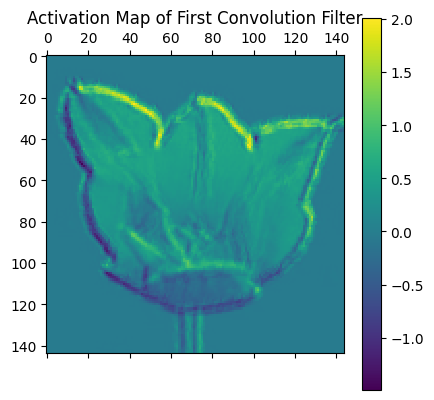

In [23]:

# Using The best model I found 
model = FlowerClassifier()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  
train_validate_model("SGD", model, optimizer, criterion, train_loader, valid_loader, num_epochs, device)

# Select an Input Image
data_iter = iter(valid_loader)
images, labels = next(data_iter)

img = images[0].unsqueeze(0)  # take the first image from the batch
img = img.to(device)

# Forward Propagation to the Desired Convolution Layer
activations = []
def hook_fn(module, input, output):
    activations.append(output)
# I will show the silence map of "conv1" layer.
hook = model.conv1.register_forward_hook(hook_fn)  
output = model(img)
hook.remove()
activation_map = activations[0].squeeze(0)

# Visualize the Activation Map
plt.matshow(activation_map[0].cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title("Activation Map of First Convolution Filter")
plt.show()

### 8-What changes to the network architecture can improve the results? Show the modified model with the results. 

Epoch 1/20 - Train Loss: 1.3481  Train Acc: 0.4515  Val Loss: 1.0716  Val Acc: 0.5737
Epoch 2/20 - Train Loss: 1.1071  Train Acc: 0.5479  Val Loss: 1.0116  Val Acc: 0.5922
Epoch 3/20 - Train Loss: 1.0451  Train Acc: 0.5647  Val Loss: 1.0419  Val Acc: 0.5853
Epoch 4/20 - Train Loss: 1.0012  Train Acc: 0.6126  Val Loss: 0.9579  Val Acc: 0.6313
Epoch 5/20 - Train Loss: 0.9559  Train Acc: 0.6184  Val Loss: 0.9680  Val Acc: 0.6037
Epoch 6/20 - Train Loss: 0.8986  Train Acc: 0.6259  Val Loss: 0.9416  Val Acc: 0.6498
Epoch 7/20 - Train Loss: 0.8959  Train Acc: 0.6386  Val Loss: 0.9166  Val Acc: 0.6544
Epoch 8/20 - Train Loss: 0.9105  Train Acc: 0.6345  Val Loss: 0.8923  Val Acc: 0.6498
Epoch 9/20 - Train Loss: 0.8545  Train Acc: 0.6617  Val Loss: 0.8962  Val Acc: 0.6336
Epoch 10/20 - Train Loss: 0.8187  Train Acc: 0.6640  Val Loss: 0.9456  Val Acc: 0.6728
Epoch 11/20 - Train Loss: 0.8203  Train Acc: 0.6674  Val Loss: 0.8429  Val Acc: 0.6682
Epoch 12/20 - Train Loss: 0.7927  Train Acc: 0.6934 

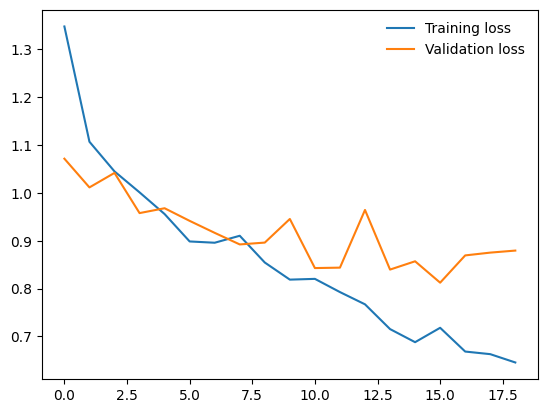

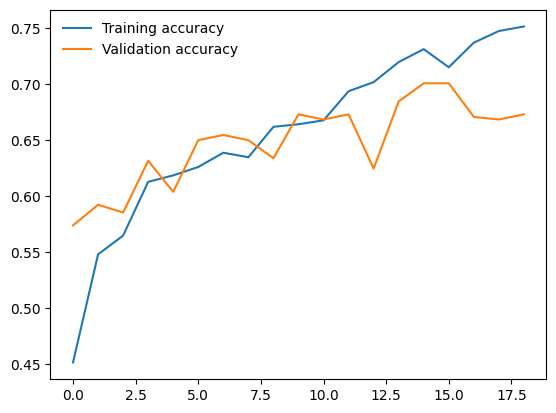

Test Loss: 0.8327  Test Acc: 0.6575


In [27]:
# There are many changes that can be applied and that may improve the results such as:
# Increase Depth, Adding more Batch Normalization layers, Change Activation Functions, etc.
# I will add Batch Normalization after every convolution layer, an additional convolution layer, and a dropout before the final fully connected layer.

class NewFlowerClassifier(nn.Module):
    def __init__(self):
        super(NewFlowerClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(41472, 512)  
        self.fc2 = nn.Linear(512, 5)  
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2, 2)
#         x = x.view(-1, 41472)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
# Initialize the model, loss function, and optimizer
model = NewFlowerClassifier()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=best_lr, weight_decay=best_reg, momentum=0.9)  

early_stopper = EarlyStopper(patience=3, min_delta=0.001)
num_epochs = 20

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training loop
    model.train()  # set the model to training mode
    train_loss = 0.0
    train_corrects = 0
    for inputs, labels in train_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        
        train_corrects += accuracy_s(outputs, labels) * labels.size(0)

    # Validation loop
    model.eval()  # set the model to evaluation mode
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            val_corrects += accuracy_s(outputs, labels) * labels.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(valid_loader.dataset)
    
    train_accuracy = train_corrects / len(train_loader.dataset)
    val_accuracy = val_corrects / len(valid_loader.dataset)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}  Train Acc: {train_accuracy:.4f}  "
          f"Val Loss: {val_loss:.4f}  Val Acc: {val_accuracy:.4f}")
    if early_stopper.early_stop(val_loss):
            print(f"Early stopping at epoch {epoch + 1}")
            break
# Plotting
plot_train_val_loss(train_losses, val_losses)
plot_train_val_accuracy(train_accuracies, val_accuracies)

# part e: showing the accuracy on test data
model.eval()  # set the model to evaluation mode
test_corrects = 0
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
        test_corrects += accuracy_s(outputs, labels) * labels.size(0)

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = test_corrects / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}  Test Acc: {test_accuracy:.4f}")

# PART 2 (Transfer Learning)

### 1-VGG16

In [75]:
# from import VGG16_Weights
vgg16 = models.vgg16_bn()
vgg16.load_state_dict(torch.load('/kaggle/input/weights/vgg16_bn-6c64b313.pth'))
print(vgg16) # print to see the arch to modify it
# freeze
for param in vgg16.parameters():
    param.requires_grad = False
    
vgg16.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 5)
)


vgg16.to(device)
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
train_validate_model("VGG16", vgg16, optimizer, criterion, train_loader, valid_loader, epochs=20, device=device)

    

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

([1.60849986891273,
  1.5912802775517347,
  1.5699879985483358,
  1.5364924751858788,
  1.4744474551969533,
  1.3565078687447598,
  1.151547182239506,
  0.9076565462777576,
  0.728862450524786,
  0.5874020431113298,
  0.49385788651316603,
  0.4143277863019058,
  0.3652580960655873,
  0.30959226579919424,
  0.28323359522478136,
  0.25002203885181945,
  0.2268700918686032,
  0.22544156073422686,
  0.20551486643715214,
  0.17637650737448599],
 [1.6001457986743768,
  1.5811495802918887,
  1.555811919924301,
  1.510149456938291,
  1.4248925782568445,
  1.2476636836056336,
  1.0289925809280114,
  0.793725354605556,
  0.6432344548163875,
  0.5189903252135774,
  0.442589651467064,
  0.385132403967018,
  0.34494993447708094,
  0.307490780400241,
  0.30044983258719815,
  0.28543218276742416,
  0.2779116589352832,
  0.259608865745606,
  0.2605090398804933,
  0.23840807508763082],
 [tensor(0.2442, device='cuda:0', dtype=torch.float64),
  tensor(0.3360, device='cuda:0', dtype=torch.float64),
  tens

### 2-inception_v3

In [74]:
# inception needs large pictures, so: 
# c: Define transformations to perfrom data augementation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((300, 300)),  # Resize images to a single standard size. I chose 150x150 because it is not too large to be computationally intensive nor too small to lose critical details
        # Start part C: Data augmentation #
        transforms.RandomRotation(20),  # Rotation augmentation by 20 degrees (specified in part C)
        transforms.RandomHorizontalFlip(),  # Horizontal flip augmentation (specified in part C) 
        # End of part C: Data augmentation #
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ]),
    'test': transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}
# Load datasets
train_dataset = ImageFolder(root_train, transform=data_transforms['train'])
test_dataset = ImageFolder(root_test, transform=data_transforms['test'])
# Split train dataset into training and validation
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

# Create dataloaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

inception = models.inception_v3() # Load the pretrained InceptionV3 model
inception.to(device)
inception.load_state_dict(torch.load('/kaggle/input/weights/inception_v3_google-0cc3c7bd.pth'))

test_corrects = 0
test_loss = 0.0
inception.eval()
with torch.no_grad():
    inception.to(device)
    for inputs, labels in test_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = inception(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
        test_corrects += accuracy_s(outputs, labels) * labels.size(0)

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = test_corrects / len(test_loader.dataset)
print(f"Test Loss without Fine-tuning: {test_loss:.4f}, Test Accuracy without Fine-tuning: {test_accuracy:.2f}")
test_accuracy_without = test_accuracy
inception.AuxLogits.fc = nn.Linear(inception.AuxLogits.fc.in_features, 5)
inception.fc = nn.Linear(inception.fc.in_features, 5)

test_corrects = 0
test_loss = 0.0

with torch.no_grad():
    inception.to(device)
    for inputs, labels in test_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = inception(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
        test_corrects += accuracy_s(outputs, labels) * labels.size(0)

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = test_corrects / len(test_loader.dataset)
print(f"Test Loss with the modified layers (part b): {test_loss:.4f}, Test Accuracy with the modified layers (part b): {test_accuracy:.2f}")
test_accuracy_fine_tuned = test_accuracy

# Freeze all layers except the last two
for param in inception.parameters():
    param.requires_grad = False

for param in inception.AuxLogits.fc.parameters():
    param.requires_grad = True

for param in inception.fc.parameters():
    param.requires_grad = True

# Train the inception
optimizer = optim.SGD([
    {'params': inception.AuxLogits.fc.parameters()},
    {'params': inception.fc.parameters()}
], lr=0.001, momentum=0.9)

# train_validate_model("InceptionV3_fine_tuned", inception, optimizer, criterion, train_loader, valid_loader, epochs=5, device=device)
# train
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

early_stopper = EarlyStopper(patience=3, min_delta=0.001)
print(f"==== Results for inception ====")
for epoch in range(epochs):
    # Training loop
    inception.train()  # set the model to training mode
    train_loss = 0.0
    train_corrects = 0
    for inputs, labels in train_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, _ = inception(inputs)
        loss = criterion(outputs, labels)
        try:
            loss.backward()
        except: 
            pass
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        train_corrects += accuracy_s(outputs, labels) * labels.size(0)

    # Validation loop
    inception.eval()  # set the model to evaluation mode
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = inception(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            val_corrects += accuracy_s(outputs, labels) * labels.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(valid_loader.dataset)

    train_accuracy = train_corrects / len(train_loader.dataset)
    val_accuracy = val_corrects / len(valid_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Loss: {train_loss:.4f}  Train Acc: {train_accuracy:.4f}  "
          f"Val Loss: {val_loss:.4f}  Val Acc: {val_accuracy:.4f}")

    if early_stopper.early_stop(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break






test_corrects = 0
test_loss = 0.0

with torch.no_grad():
    inception.to(device)
    for inputs, labels in test_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = inception(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
        test_corrects += accuracy_s(outputs, labels) * labels.size(0)

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = test_corrects / len(test_loader.dataset)
print(f"Test Loss after training: {test_loss:.4f}, Test Accuracy after training: {test_accuracy:.2f}")
test_accuracy_full_train = test_accuracy

print(f"Test Accuracy without Fine-tuning: {test_accuracy_without:.2f}%")
print(f"Test Accuracy with Fine-tuning: {test_accuracy_fine_tuned:.2f}%")
print(f"Test Accuracy after Full Training: {test_accuracy_full_train:.2f}%")


Test Loss without Fine-tuning: 9.2032, Test Accuracy without Fine-tuning: 0.00
Test Loss with the modified layers (part b): 1.6258, Test Accuracy with the modified layers (part b): 0.25
==== Results for inception ====
Epoch 1/20 - Train Loss: 1.4281  Train Acc: 0.4088  Val Loss: 1.1603  Val Acc: 0.7327
Epoch 2/20 - Train Loss: 1.0640  Train Acc: 0.6744  Val Loss: 0.9188  Val Acc: 0.7972
Epoch 3/20 - Train Loss: 0.8887  Train Acc: 0.7419  Val Loss: 0.8050  Val Acc: 0.8088
Epoch 4/20 - Train Loss: 0.7821  Train Acc: 0.7691  Val Loss: 0.7288  Val Acc: 0.8134
Epoch 5/20 - Train Loss: 0.7385  Train Acc: 0.7564  Val Loss: 0.6841  Val Acc: 0.8571
Epoch 6/20 - Train Loss: 0.6867  Train Acc: 0.7898  Val Loss: 0.5980  Val Acc: 0.8502
Epoch 7/20 - Train Loss: 0.6688  Train Acc: 0.7737  Val Loss: 0.5732  Val Acc: 0.8687
Epoch 8/20 - Train Loss: 0.6214  Train Acc: 0.8066  Val Loss: 0.5488  Val Acc: 0.8594
Epoch 9/20 - Train Loss: 0.6178  Train Acc: 0.7956  Val Loss: 0.5434  Val Acc: 0.8525
Epoch 10

ignore the precentage mark of the accuracies above